[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1_gCcAXGYgX_ryc153MW5PsCkRE4Fg9sj?usp=sharing)

Source: https://github.com/ezponda/intro_deep_learning/blob/main/class/RNN/img2seq.ipynb

## Generate CAPTCHA Dataset

In [ ]:
import string
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow as tf
from IPython.display import Image, display

In [ ]:
chars = set()
#chars.update(string.ascii_lowercase)
#chars.update(string.ascii_uppercase)
chars.update({str(i) for i in range(10)})
chars = sorted(chars)
print('Number of chars: {0}, chars: {1}'.format(len(chars), chars))

Number of chars: 10, chars: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
img_dir = './captcha/'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

In [ ]:
!pip install -U captcha==0.3

In [ ]:
from captcha.image import ImageCaptcha
import uuid
create_dataset = True
captcha_len = 3
width = 40 + 20 * captcha_len
height = 100
n_images = 40000
if create_dataset:
    image = ImageCaptcha(width = width, height = height)
    print('Sample captcha str', np.random.choice(chars, captcha_len))
    seen = set()
    for _ in tqdm(range(n_images)):
        combi = np.random.choice(chars, captcha_len)
        captcha = ''.join(combi)
        image.write(captcha, '{0}{1}_{2}.png'.format(img_dir, captcha, uuid.uuid4()))

Sample captcha str ['5' '8' '7']


100%|██████████| 40000/40000 [03:32<00:00, 188.08it/s]


In [ ]:
print('Number of captchas', len(os.listdir(img_dir)))
print('Some captchas', os.listdir(img_dir)[:5])

Number of captchas 40000
Some captchas ['611_1e0f6c82-b6fd-4483-96e1-4f8f635c3a49.png', '069_966d08e6-243a-4c50-b03c-61ed16e1befd.png', '096_748f6b94-bd22-4b4e-8233-38828cb5b021.png', '817_4ea1f465-17f2-4bc8-9f58-4c286ead6a02.png', '502_7d4740a2-6c3c-4f83-832c-378cde730b9b.png']


image shape:  (100, 100, 3)


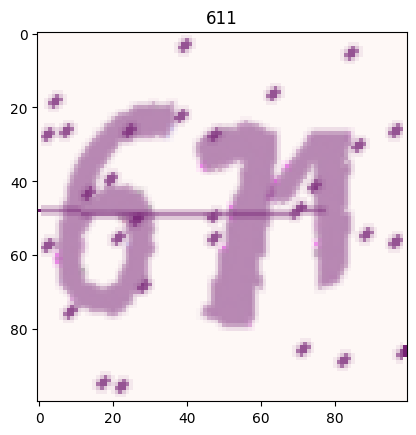

In [ ]:
## Plot first sample
name = os.listdir(img_dir)[0]
x = tf.keras.preprocessing.image.load_img(os.path.join(img_dir, name))
x = tf.keras.preprocessing.image.img_to_array(x).astype(np.uint8)
print('image shape: ', x.shape)
plt.imshow(x)
plt.title(name.split('_')[0])
plt.show()

## Preprocessing data

Number of images found:  40000
Number of labels found:  40000
Number of unique characters:  10
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


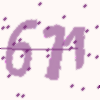

captcha: 611


In [ ]:
data_dir = img_dir
# Get list of all the images
images, labels = zip(*[(os.path.join(img_dir, name), name.split('_')[0])
                       for name in os.listdir(img_dir)])
images, labels = (np.array(list(images)), np.array(list(labels)))
characters = sorted(set(char for label in labels for char in label))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)
display(Image(images[0]))
print('captcha:', labels[0])

### Characters processing
For converting the characters to one-hot encoding, we will use [tf.keras.layers.StringLookup
](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup).
```python
tf.keras.layers.StringLookup(
    max_tokens=None, num_oov_indices=1, mask_token='',
    oov_token='[UNK]', vocabulary=None, encoding=None, invert=False,
    **kwargs
)
```

In [ ]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), num_oov_indices=0,
    mask_token=None, invert=True
)


train_samples = int(0.7 * len(images))
val_split = int(0.8 * len(images))
x_train, y_train = images[:train_samples], labels[:train_samples]
x_val, y_val = images[train_samples:val_split], labels[train_samples:val_split]
x_test, y_test = images[val_split:], labels[val_split:]
print('x_train, y_train shape: ', x_train.shape, y_train.shape)

def encode_single_sample(img_path, label):

    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    zeros = tf.zeros((captcha_len,1))
    return ((img, zeros), label)


/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


x_train, y_train shape:  (28000,) (28000,)


### Generate Datasets

In [ ]:
batch_size = 128
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(encode_single_sample)
train_dataset = train_dataset.batch(batch_size).cache().shuffle(50).prefetch(buffer_size=AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).map(encode_single_sample)
validation_dataset = validation_dataset.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(encode_single_sample)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE).batch(batch_size)

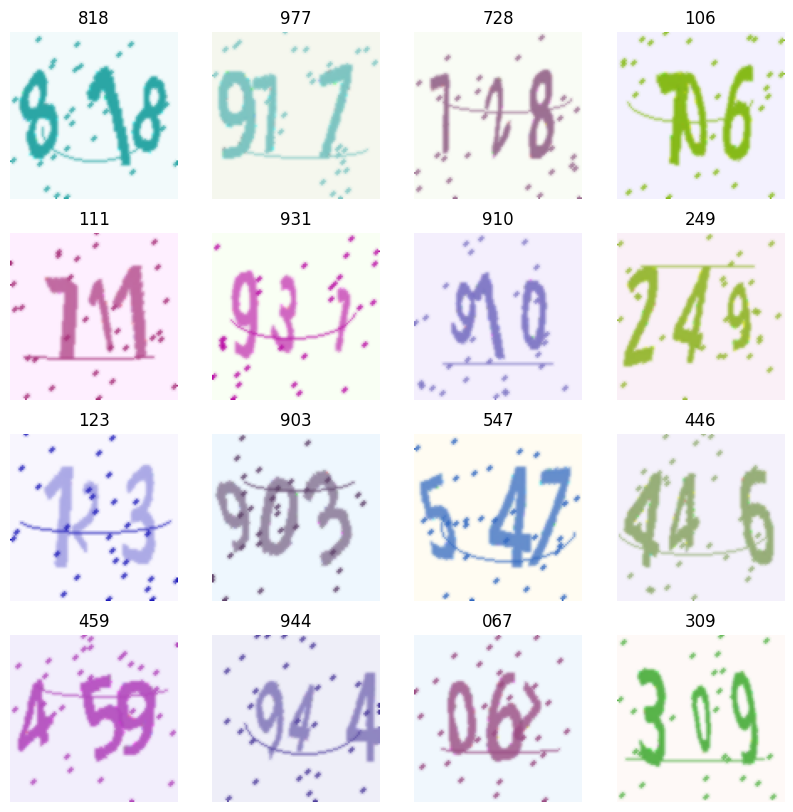

In [ ]:
# plot samples
_, ax = plt.subplots(4, 4, figsize=(10, 10))
for (images_batch, zeros_batch), labels_batch in train_dataset.take(1):
    for i in range(16):
        img = (images_batch[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels_batch[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Questions 1: Create a model like a seq2seq
Study the impact of `encoder_vec_dim` on the performance of the model.

In [ ]:
encoder_vec_dim = 256  # dimension of the encoder vector

encoder_input = tf.keras.Input(shape=(width, height, 3),
                               name='encoder_input')

# First conv block
x = layers.Conv2D(
    16,
    (3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="valid",
    name="Conv1",
)(encoder_input)
x = layers.MaxPooling2D((2, 2), name="pool1")(x)
x = layers.Dropout(0.3)(x)

# Second conv block
x = layers.Conv2D(
    16,
    (3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="valid",
    name="Conv2",
)(x)
x = layers.MaxPooling2D((2, 2), name="pool2")(x)

# Third conv block
x = layers.Conv2D(
    16,
    (3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="valid",
    name="Conv3",
)(x)
x = layers.MaxPooling2D((2, 2), name="pool3")(x)


x = layers.Flatten()(x)
x = layers.Dense(encoder_vec_dim, activation='relu')(x)
encoded_vector = [x, x]



# Decoder
decoder_input = tf.keras.Input(shape=(captcha_len, 1),
                               name='decoder_input')

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(encoder_vec_dim, return_sequences=True,
                             name="decoder_1")(decoder_input,
                                             initial_state=encoded_vector)


decoder_output = layers.Dropout(0.25)(decoder_output)
output = layers.TimeDistributed(layers.Dense(len(characters)+1, activation='softmax'))(decoder_output)

model = tf.keras.Model([encoder_input, decoder_input], output)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 98, 98, 16)           448       ['encoder_input[0][0]']       
                                                                                                  
 pool1 (MaxPooling2D)        (None, 49, 49, 16)           0         ['Conv1[0][0]']               
                                                                                                  
 dropout (Dropout)           (None, 49, 49, 16)           0         ['pool1[0][0]']               
                                                                                              

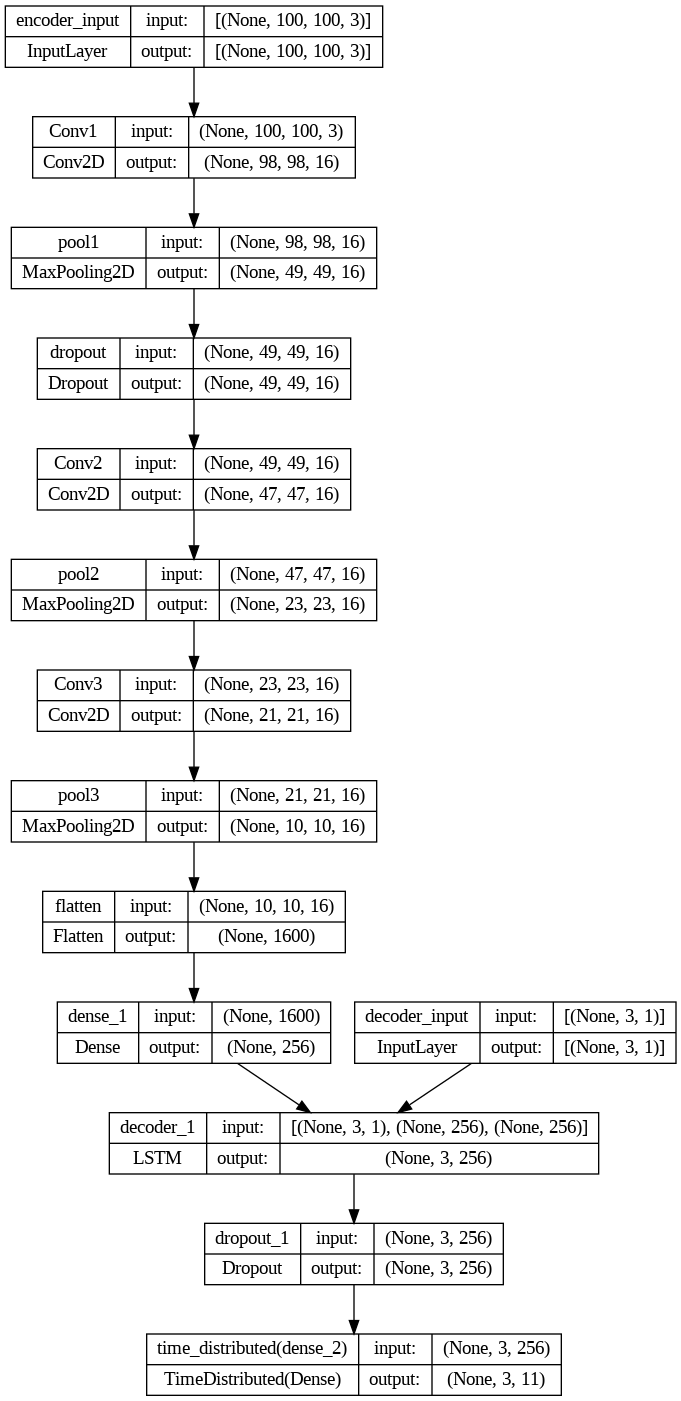

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

In [ ]:
epochs = 300
early_stopping_patience = 50
# Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
)

Epoch 1/300
219/219 [==============================] - 34s 82ms/step - loss: 2.2596 - accuracy: 0.1361 - val_loss: 2.0148 - val_accuracy: 0.2809
Epoch 2/300
219/219 [==============================] - 5s 21ms/step - loss: 1.4409 - accuracy: 0.4645 - val_loss: 0.8623 - val_accuracy: 0.7027
Epoch 3/300
219/219 [==============================] - 5s 21ms/step - loss: 0.6338 - accuracy: 0.7802 - val_loss: 0.3947 - val_accuracy: 0.8679
Epoch 4/300
219/219 [==============================] - 4s 20ms/step - loss: 0.3419 - accuracy: 0.8855 - val_loss: 0.2440 - val_accuracy: 0.9193
Epoch 5/300
219/219 [==============================] - 5s 21ms/step - loss: 0.2210 - accuracy: 0.9270 - val_loss: 0.1839 - val_accuracy: 0.9370
Epoch 6/300
219/219 [==============================] - 5s 21ms/step - loss: 0.1621 - accuracy: 0.9469 - val_loss: 0.1486 - val_accuracy: 0.9496
Epoch 7/300
219/219 [==============================] - 5s 21ms/step - loss: 0.1199 - accuracy: 0.9603 - val_loss: 0.1149 - val_accuracy

### Evaluate Test Results

In [ ]:
results = model.evaluate(test_dataset, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

63/63 [==============================] - 10s 152ms/step - loss: 0.0936 - accuracy: 0.9820
Test Loss: 0.09356000274419785
Test Accuracy: 0.9820416569709778


4/4 [==============================] - 0s 5ms/step


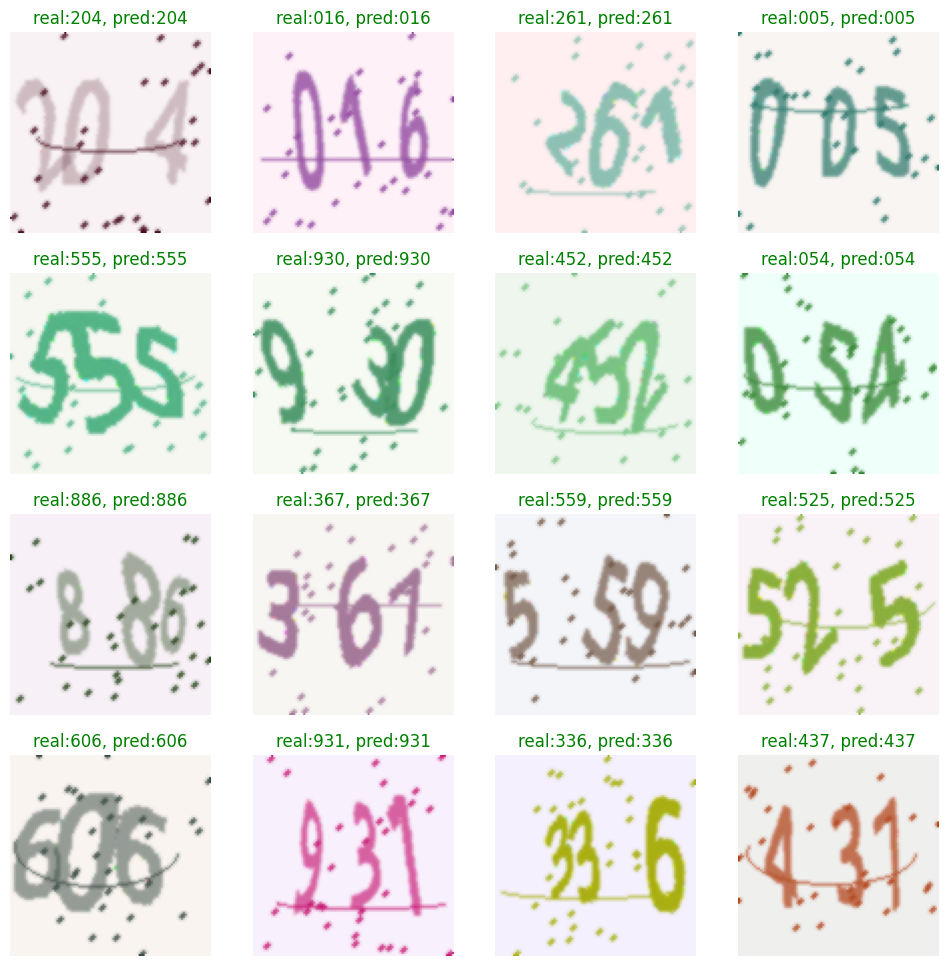

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(12, 12))
for (images_batch, zeros_batch), labels_batch in test_dataset.take(1):
    y_preds = model.predict([images_batch, zeros_batch]).argmax(-1)
    for i in range(16):
        img = (images_batch[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(
            labels_batch[i])).numpy().decode("utf-8")
        label_pred = tf.strings.reduce_join(num_to_char(
            y_preds[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        if label == label_pred:
            ax[i // 4,
               i % 4].set_title('real:{0}, pred:{1}'.format(label, label_pred),
                                color='green')
        else:
            ax[i // 4,
               i % 4].set_title('real:{0}, pred:{1}'.format(label, label_pred),
                                color='red')
        ax[i // 4, i % 4].axis("off")

plt.show()